In [1]:

import random
import pandas as pd
import numpy as np
import awkward as ak
import matplotlib as mpl
import matplotlib.pyplot as plt
import mplhep as hep
import boost_histogram as bh
import json
from sklearn.metrics import classification_report, roc_auc_score
from scipy import interpolate
from sklearn.metrics import roc_curve, auc
from cycler import cycler
# from awkward import ak
import os

import uproot ## means uproot4
import sklearn.metrics as m

use_helvet = False ## true: use helvetica for plots, make sure the system have the font installed
if use_helvet:
    CMShelvet = hep.style.CMS
    CMShelvet['font.sans-serif'] = ['Helvetica', 'Arial']
    plt.style.use(CMShelvet)
else:
    plt.style.use(hep.style.CMS)


# env: HWW

In [2]:

CustNanoData = {
    
    'SingleMuon'   : "/data/pubfs/zhaoyz/Tree/V8/2017/Merged/SingleMuon/Tree_SingleMuon.root",
    # 'JetHT'        : "/data/pubfs/zhaoyz/Tree/V8/2017/Merged/Data/Tree_Data.root",            
    'QCD'          : "/data/pubfs/zhaoyz/Tree/V8/2017/Merged/MC/Tree_QCD.root",            
    # 'Signal'       : "/data/pubfs/zhaoyz/Tree/V8/2017/Merged/Signal/Tree_Total.root",
    # 'GluGlu'       : "/data/pubfs/zhaoyz/Tree/V8/2017/Merged/Signal/Tree_GluGlu.root",            
    # 'VH'           : "/data/pubfs/zhaoyz/Tree/V8/2017/Merged/Signal/Tree_VH.root",            
    # 'VBF'          : "/data/pubfs/zhaoyz/Tree/V8/2017/Merged/Signal/Tree_VBF.root",            
    # 'ttH'          : "/data/pubfs/zhaoyz/Tree/V8/2017/Merged/Signal/Tree_ttH.root",            
           
}
events = {typefile : {} for typefile in CustNanoData}
for typefile in CustNanoData:
    events[typefile] = uproot.lazy({CustNanoData[typefile]: "PKUTree" }) ## lazy means lazy computation style
    # for var in ak_arrays.fields:
    #     if "HLT" in var or "FatJet" in var:
    #         events[year][var] = ak_arrays[var]

In [3]:
MAIN_DIR = ".."

plot_dir = f"{MAIN_DIR}/plots/trigger/8Mar24"
_ = os.system(f"mkdir -p {plot_dir}")

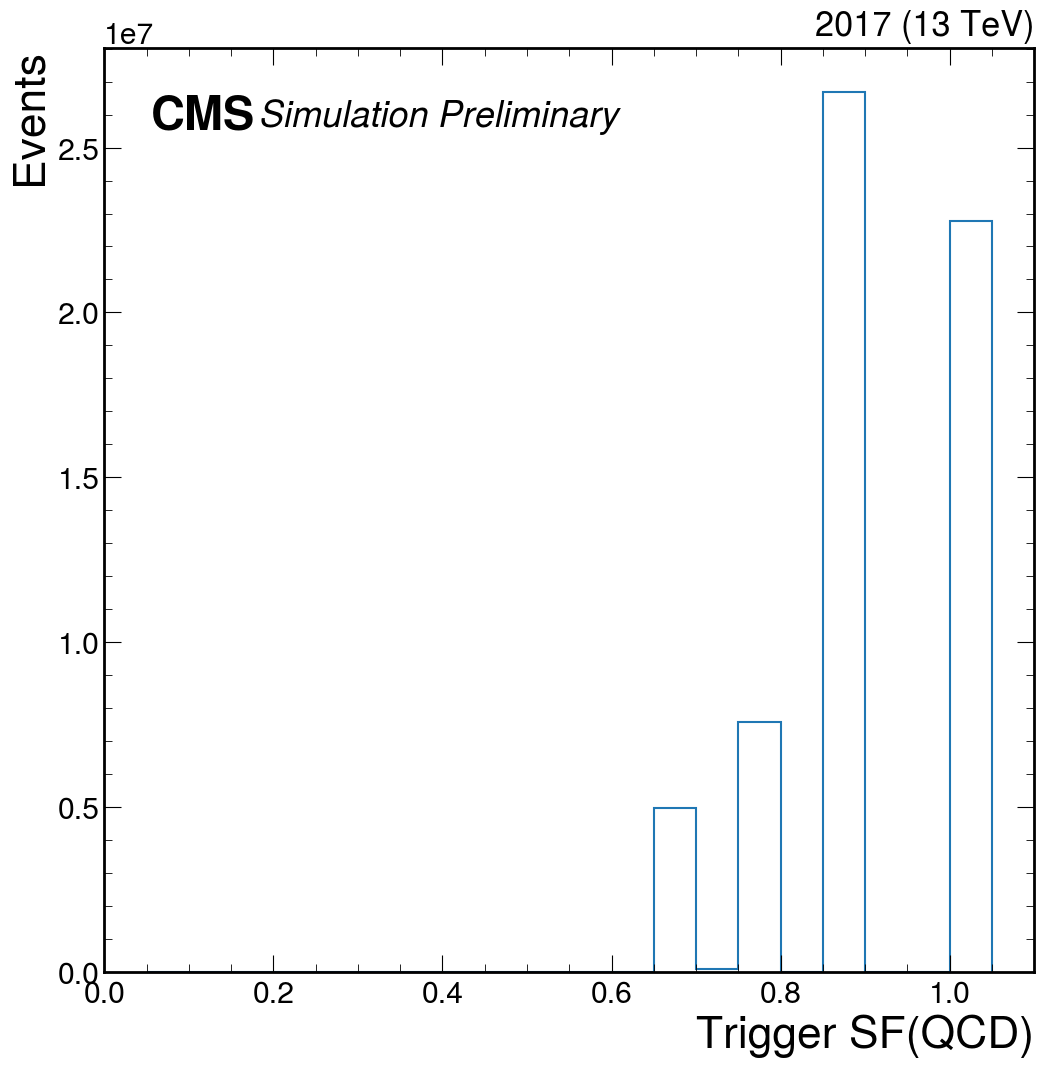

In [4]:
SFbins, SFmin, SFmax = 20, 0.05, 1.05
plt.figure(figsize=(12,12))
ax=plt.gca()
hep.cms.label(data= False, label = "Preliminary", year="2017", ax=ax, fontname='sans-serif', loc = 1)
hist1DSF = bh.Histogram(bh.axis.Regular(SFbins, SFmin, SFmax),storage=bh.storage.Weight())
eventsCut = events["QCD"][events["QCD"]["TriggerSF"] > 0.3]
hist1DSF.fill(eventsCut["TriggerSF"],weight = eventsCut["weight"])
h, err = hist1DSF.view().value, np.sqrt(hist1DSF.view().variance)
hep.histplot(h, bins=hist1DSF.axes[0].edges, yerr=err, histtype='step', stack=False)
plt.xlabel(r"Trigger SF(QCD)", fontsize=32, ha='right', x=1)
plt.ylabel(r"Events", fontsize=32, ha='right', y=1)
plt.savefig(f"{plot_dir}/2017QCDTriggerSF.pdf", bbox_inches='tight')
plt.show()

In [5]:
#Plot 2D trigger efficiency SFs uncertainty.
def SF2DUnc_withvalue(eventsMC,eventsData, x_label, y_label, isData = True, xmin = 200, xmax = 1200, bins = 500, legend_location='best'):
    if x_label == y_label: return
    """
    events: a dictionary, events.values() are collections of events
    """
    x_score, y_score = 'score_'+x_label, 'score_'+y_label
    # ax = plt.figure(figsize=(10,10))
    plt.figure(figsize=(15,12))
    ax=plt.gca()
    # fig ,ax = plt.subplots()
    hep.cms.label(data= isData, label = "Preliminary", year="2017", ax=ax, fontname='sans-serif')
    mmin = 40.0
    mmax = 240.0
    mbins = 20

    ptmin = 200.0
    ptmax = 600.0
    ptbins = 20
    
    hist2DMC = bh.Histogram(bh.axis.Regular(mbins, mmin, mmax),bh.axis.Regular(ptbins, ptmin, ptmax),storage=bh.storage.Weight())
    hist2DMC.fill(eventsMC["Mj_V2_a"],eventsMC["PTj_V2_a"],weight = eventsMC["weight"])

    eventsMC_Cut = eventsMC[ (eventsMC["HLT_PFJet500"] == True)  | (eventsMC["HLT_AK8PFJet500"] == True) | (eventsMC["HLT_AK8PFJet360_TrimMass30"] == True) | (eventsMC["HLT_PFHT1050"] == True) | (eventsMC["HLT_AK8PFJet380_TrimMass30"] == True) | (eventsMC["HLT_AK8PFJet400_TrimMass30"] == True) | (eventsMC["HLT_AK8PFJet420_TrimMass30"] == True) | (eventsMC["HLT_AK8PFHT750_TrimMass50"] == True) | (eventsMC["HLT_AK8PFHT800_TrimMass50"] == True) | (eventsMC["HLT_AK8PFHT850_TrimMass50"] == True) | (eventsMC["HLT_AK8PFHT900_TrimMass50"] == True)]
    
    hist2DMC_Cut = bh.Histogram(bh.axis.Regular(mbins, mmin, mmax),bh.axis.Regular(ptbins, ptmin, ptmax),storage=bh.storage.Weight())
    hist2DMC_Cut.fill(eventsMC_Cut["Mj_V2_a"],eventsMC_Cut["PTj_V2_a"],weight = eventsMC_Cut["weight"]*eventsMC_Cut["TriggerSF"])

    EffiMC2D = hist2DMC_Cut.view().value / hist2DMC.view().value



    hist2DData = bh.Histogram(bh.axis.Regular(mbins, mmin, mmax),bh.axis.Regular(ptbins, ptmin, ptmax),storage=bh.storage.Weight())
    hist2DData.fill(eventsData["Mj_V2_a"],eventsData["PTj_V2_a"])

    eventsData_Cut = eventsData[ (eventsData["HLT_PFJet500"] == True) | (eventsData["HLT_AK8PFJet500"] == True) | (eventsData["HLT_AK8PFJet360_TrimMass30"] == True) | (eventsData["HLT_PFHT1050"] == True) | (eventsData["HLT_AK8PFJet380_TrimMass30"] == True) | (eventsData["HLT_AK8PFJet400_TrimMass30"] == True) | (eventsData["HLT_AK8PFJet420_TrimMass30"] == True) | (eventsData["HLT_AK8PFHT750_TrimMass50"] == True) | (eventsData["HLT_AK8PFHT800_TrimMass50"] == True) | (eventsData["HLT_AK8PFHT850_TrimMass50"] == True) | (eventsData["HLT_AK8PFHT900_TrimMass50"] == True)]
    
    hist2DData_Cut = bh.Histogram(bh.axis.Regular(mbins, mmin, mmax),bh.axis.Regular(ptbins, ptmin, ptmax),storage=bh.storage.Weight())
    hist2DData_Cut.fill(eventsData_Cut["Mj_V2_a"],eventsData_Cut["PTj_V2_a"])

    EffiData2D = hist2DData_Cut.view().value / hist2DData.view().value


    Effi2DSF = EffiData2D/EffiMC2D

    #Start to calculate the uncentainty.
    Invera = 1./hist2DData_Cut.view().value
    Inverc = 1./hist2DData.view().value
    Inverb = 1./hist2DMC.view().value
    Inverd = 1./hist2DMC_Cut.view().value
    Sa = hist2DData_Cut.view().variance
    Sc = hist2DData.view().variance
    Sb = hist2DMC.view().variance
    Sd = hist2DMC_Cut.view().variance
                
    RelaUnc = np.sqrt( (Invera**2) * Sa + (Inverb**2) * Sb + (Inverc**2) * Sc + (Inverd**2) * Sd )
    Unc = Effi2DSF * RelaUnc

    #define mesh
    mesh = ax.pcolormesh(*hist2DMC.axes.edges.T, Unc.T , vmin = 0, vmax = 1 )
    xedges = hist2DMC.axes[0].edges
    # print(xedges)
    yedges = hist2DMC.axes[1].edges
    # print(yedges)
    h = Unc
    # print(h)
    meshed_value = []
    for i in range(len(xedges)-1):
        for j in range(len(yedges)-1):
            print("When mass = ",xedges[i]," pT = ", yedges[j],"SF = ",h[i,j])
            if h[i,j] >= 0 and h[i,j] <= 5: 
                SFij = h[i,j] 
            else : SFij = 1
            dict_tmp = {
                "mass":xedges[i],
                "pT"  :yedges[j],
                "SF"  :SFij
                }
            meshed_value.append(dict_tmp)
            # print(h[i,j])
            plt.text(xedges[i]+0.5*(xedges[i+1]-xedges[i]), yedges[j]+0.5*(yedges[j+1]-yedges[j]), round(h[i,j],2), color='white', ha='center', va='center',fontsize = 14)
    with open('mesh_data_2017_unc.json', 'w') as json_file:
        json.dump(meshed_value, json_file)
    cbar = plt.colorbar(mesh)
    cbar.set_label('Trigger efficiency scale factor uncertainty', rotation= 90,fontsize=32)
    # plt.title('Trigger efficiency scale factor', fontsize=32,color="black", x = 0.3, y = 0.9)

    plt.xlabel(r"Higgs candidate jet $m_{SD}$", fontsize=32, ha='right', x=1)
    plt.ylabel(r"Higgs candidate $p_{T}$", fontsize=32, ha='right', y=1)
    plt.savefig(f"{plot_dir}/2017Unc" + y_label + "_vs_" + x_label + "TriggerEffiSF.pdf", bbox_inches='tight')

    plt.show()

/tmp/ipykernel_143594/1027291765.py:29: RuntimeWarning: invalid value encountered in divide
  EffiMC2D = hist2DMC_Cut.view().value / hist2DMC.view().value
/tmp/ipykernel_143594/1027291765.py:41: RuntimeWarning: invalid value encountered in divide
  EffiData2D = hist2DData_Cut.view().value / hist2DData.view().value
/tmp/ipykernel_143594/1027291765.py:47: RuntimeWarning: divide by zero encountered in divide
  Invera = 1./hist2DData_Cut.view().value
/tmp/ipykernel_143594/1027291765.py:48: RuntimeWarning: divide by zero encountered in divide
  Inverc = 1./hist2DData.view().value
/tmp/ipykernel_143594/1027291765.py:49: RuntimeWarning: divide by zero encountered in divide
  Inverb = 1./hist2DMC.view().value
/tmp/ipykernel_143594/1027291765.py:50: RuntimeWarning: divide by zero encountered in divide
  Inverd = 1./hist2DMC_Cut.view().value
/tmp/ipykernel_143594/1027291765.py:56: RuntimeWarning: invalid value encountered in multiply
  RelaUnc = np.sqrt( (Invera**2) * Sa + (Inverb**2) * Sb + (In

When mass =  40.0  pT =  200.0 SF =  0.040952033560127596
When mass =  40.0  pT =  220.0 SF =  0.038656688911354944
When mass =  40.0  pT =  240.0 SF =  0.039851846899677405
When mass =  40.0  pT =  260.0 SF =  0.04249011279688849
When mass =  40.0  pT =  280.0 SF =  0.04226269467884262
When mass =  40.0  pT =  300.0 SF =  0.04237697901997484
When mass =  40.0  pT =  320.0 SF =  0.04263912752680501
When mass =  40.0  pT =  340.0 SF =  0.04158754579902931
When mass =  40.0  pT =  360.0 SF =  0.04291531442311781
When mass =  40.0  pT =  380.0 SF =  0.040035843603791595
When mass =  40.0  pT =  400.0 SF =  0.019828544162506526
When mass =  40.0  pT =  420.0 SF =  0.026068674990327743
When mass =  40.0  pT =  440.0 SF =  0.030713917224660443
When mass =  40.0  pT =  460.0 SF =  0.036069384815936724
When mass =  40.0  pT =  480.0 SF =  0.04102312806527182
When mass =  40.0  pT =  500.0 SF =  0.044413309406968936
When mass =  40.0  pT =  520.0 SF =  0.04897412992660294
When mass =  40.0  pT 

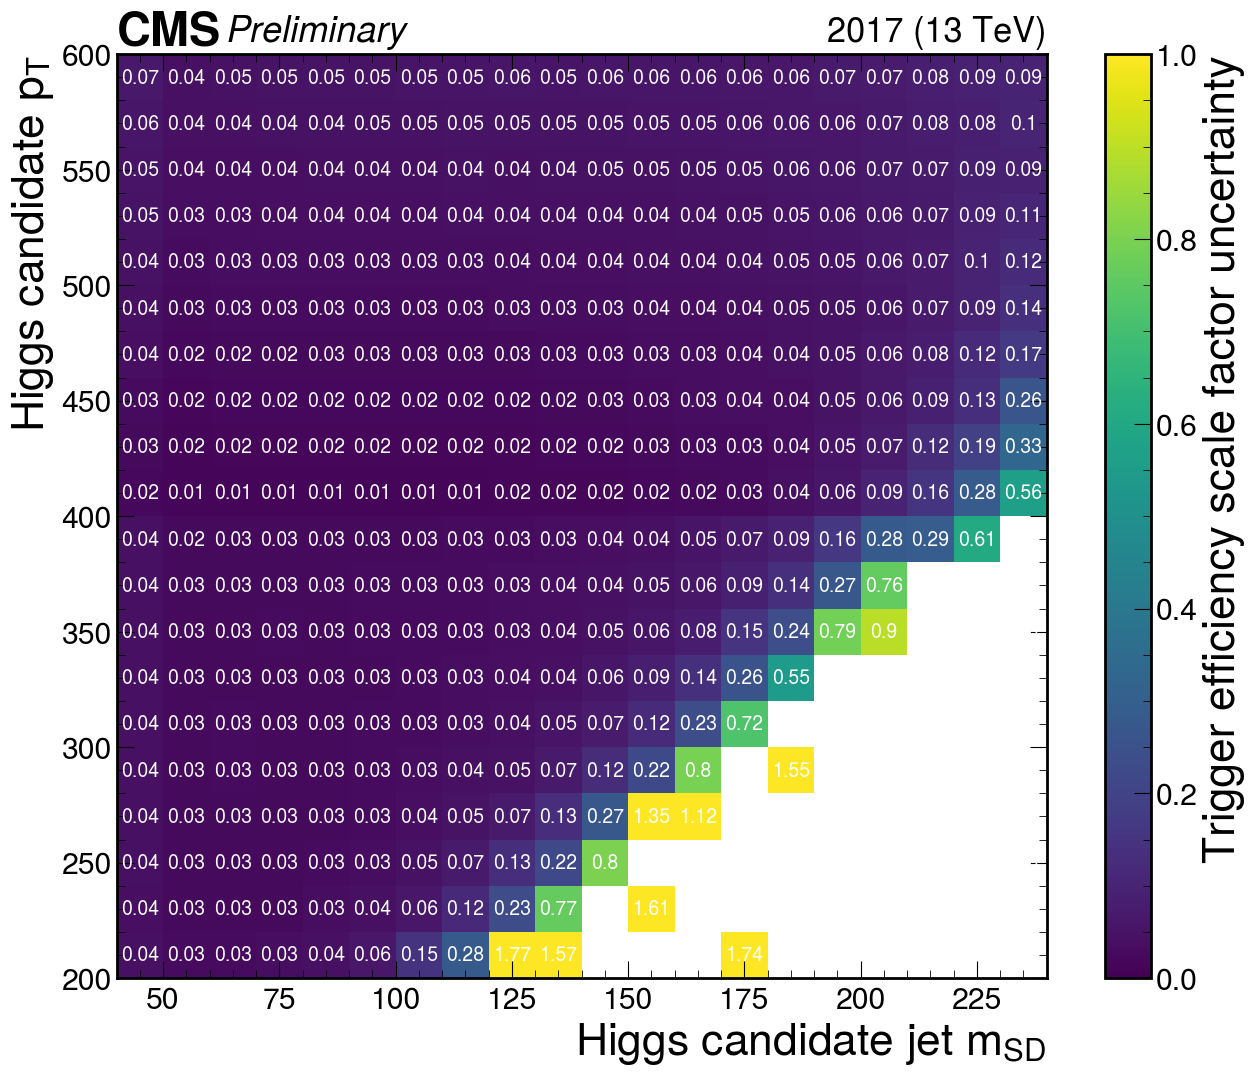

In [7]:
SF2DUnc_withvalue(eventsMC=events["QCD"], eventsData=events["SingleMuon"],x_label="Mja", y_label = "PTja",legend_location='lower right')

In [8]:
#Plot 2D trigger efficiency SFs., and with the text inside the bins.
def plot_effi_withvalue(eventsMC,eventsData, x_label, y_label, isData = True, xmin = 200, xmax = 1200, bins = 500, legend_location='best'):
    if x_label == y_label: return
    """
    events: a dictionary, events.values() are collections of events
    """
    x_score, y_score = 'score_'+x_label, 'score_'+y_label
    # ax = plt.figure(figsize=(10,10))
    plt.figure(figsize=(15,12))
    ax=plt.gca()
    # fig ,ax = plt.subplots()
    hep.cms.label(data= isData, label = "Preliminary", year="2017", ax=ax, fontname='sans-serif')
    mmin = 40.0
    mmax = 240.0
    mbins = 20

    ptmin = 200.0
    ptmax = 600.0
    ptbins = 20
    
    hist2DMC = bh.Histogram(bh.axis.Regular(mbins, mmin, mmax),bh.axis.Regular(ptbins, ptmin, ptmax),storage=bh.storage.Weight())
    hist2DMC.fill(eventsMC["Mj_V2_a"],eventsMC["PTj_V2_a"],weight = eventsMC["weight"])

    eventsMC_Cut = eventsMC[ (eventsMC["HLT_PFJet500"] == True)  | (eventsMC["HLT_AK8PFJet500"] == True) | (eventsMC["HLT_AK8PFJet360_TrimMass30"] == True) | (eventsMC["HLT_PFHT1050"] == True) | (eventsMC["HLT_AK8PFJet380_TrimMass30"] == True) | (eventsMC["HLT_AK8PFJet400_TrimMass30"] == True) | (eventsMC["HLT_AK8PFJet420_TrimMass30"] == True) | (eventsMC["HLT_AK8PFHT750_TrimMass50"] == True) | (eventsMC["HLT_AK8PFHT800_TrimMass50"] == True) | (eventsMC["HLT_AK8PFHT850_TrimMass50"] == True) | (eventsMC["HLT_AK8PFHT900_TrimMass50"] == True)]
    
    hist2DMC_Cut = bh.Histogram(bh.axis.Regular(mbins, mmin, mmax),bh.axis.Regular(ptbins, ptmin, ptmax),storage=bh.storage.Weight())
    hist2DMC_Cut.fill(eventsMC_Cut["Mj_V2_a"],eventsMC_Cut["PTj_V2_a"],weight = eventsMC_Cut["weight"]*eventsMC_Cut["TriggerSF"])

    EffiMC2D = hist2DMC_Cut.view().value / hist2DMC.view().value



    hist2DData = bh.Histogram(bh.axis.Regular(mbins, mmin, mmax),bh.axis.Regular(ptbins, ptmin, ptmax),storage=bh.storage.Weight())
    hist2DData.fill(eventsData["Mj_V2_a"],eventsData["PTj_V2_a"])

    eventsData_Cut = eventsData[ (eventsData["HLT_PFJet500"] == True) | (eventsData["HLT_AK8PFJet500"] == True) | (eventsData["HLT_AK8PFJet360_TrimMass30"] == True) | (eventsData["HLT_PFHT1050"] == True) | (eventsData["HLT_AK8PFJet380_TrimMass30"] == True) | (eventsData["HLT_AK8PFJet400_TrimMass30"] == True) | (eventsData["HLT_AK8PFJet420_TrimMass30"] == True) | (eventsData["HLT_AK8PFHT750_TrimMass50"] == True) | (eventsData["HLT_AK8PFHT800_TrimMass50"] == True) | (eventsData["HLT_AK8PFHT850_TrimMass50"] == True) | (eventsData["HLT_AK8PFHT900_TrimMass50"] == True)]
    
    hist2DData_Cut = bh.Histogram(bh.axis.Regular(mbins, mmin, mmax),bh.axis.Regular(ptbins, ptmin, ptmax),storage=bh.storage.Weight())
    hist2DData_Cut.fill(eventsData_Cut["Mj_V2_a"],eventsData_Cut["PTj_V2_a"])

    EffiData2D = hist2DData_Cut.view().value / hist2DData.view().value



    Effi2DSF = EffiData2D/EffiMC2D

    # mesh = ax.pcolormesh(*hist2DMC.axes.edges.T, Effi2DSF.T , vmin = 0, vmax = 1.5 )
    mesh = ax.pcolormesh(*hist2DMC.axes.edges.T, Effi2DSF.T, vmin = 0.8, vmax = 1.2 )
   
    xedges = hist2DMC.axes[0].edges
    # print(xedges)
    yedges = hist2DMC.axes[1].edges
    # print(yedges)
    h = Effi2DSF
    # print(h)

    meshed_value = []
    for i in range(len(xedges)-1):
        for j in range(len(yedges)-1):
            print("When mass = ",xedges[i]," pT = ", yedges[j],"SF = ",h[i,j])
            if h[i,j] >= 0 and h[i,j] <= 5: 
                SFij = h[i,j] 
            else : SFij = 1
            dict_tmp = {
                "mass":xedges[i],
                "pT"  :yedges[j],
                "SF"  :SFij
                }
            meshed_value.append(dict_tmp)
            # print(h[i,j])
            plt.text(xedges[i]+0.5*(xedges[i+1]-xedges[i]), yedges[j]+0.5*(yedges[j+1]-yedges[j]), round(h[i,j],2), color='white', ha='center', va='center',fontsize = 14)
    with open('mesh_data_2017.json', 'w') as json_file:
        json.dump(meshed_value, json_file)
    
    cbar = plt.colorbar(mesh)
    cbar.set_label('Trigger efficiency scale factor', rotation= 90,fontsize=32)
    # plt.title('Trigger efficiency scale factor', fontsize=3
    # 2,color="black", x = 0.35, y = 0.9)
    plt.xlabel(r"Higgs candidate jet $m_{SD}$", fontsize=32, ha='right', x=1)
    plt.ylabel(r"Higgs candidate $p_{T}$", fontsize=32, ha='right', y=1)
    # plt.savefig("./2DSFPlots/2017Max1p5" + y_label + "_vs_" + x_label + "TriggerEffiSF.pdf", bbox_inches='tight')
    plt.savefig(f"{plot_dir}/2018WithValue" + y_label + "_vs_" + x_label + "TriggerEffiSF.pdf", bbox_inches='tight')

    plt.show()

/tmp/ipykernel_143594/3624643707.py:29: RuntimeWarning: invalid value encountered in divide
  EffiMC2D = hist2DMC_Cut.view().value / hist2DMC.view().value
/tmp/ipykernel_143594/3624643707.py:41: RuntimeWarning: invalid value encountered in divide
  EffiData2D = hist2DData_Cut.view().value / hist2DData.view().value


When mass =  40.0  pT =  200.0 SF =  0.8536748012756867
When mass =  40.0  pT =  220.0 SF =  0.8693524423088316
When mass =  40.0  pT =  240.0 SF =  0.8698589895653518
When mass =  40.0  pT =  260.0 SF =  0.8966243710510079
When mass =  40.0  pT =  280.0 SF =  0.8821454893153239
When mass =  40.0  pT =  300.0 SF =  0.8581092554154098
When mass =  40.0  pT =  320.0 SF =  0.8838959377030932
When mass =  40.0  pT =  340.0 SF =  0.8588854005461284
When mass =  40.0  pT =  360.0 SF =  0.9174520700400611
When mass =  40.0  pT =  380.0 SF =  0.8863756069037773
When mass =  40.0  pT =  400.0 SF =  0.6654673097660324
When mass =  40.0  pT =  420.0 SF =  0.8444546276251873
When mass =  40.0  pT =  440.0 SF =  0.9403791820162652
When mass =  40.0  pT =  460.0 SF =  1.0057434351208676
When mass =  40.0  pT =  480.0 SF =  1.0345911536925914
When mass =  40.0  pT =  500.0 SF =  1.0256685089804183
When mass =  40.0  pT =  520.0 SF =  1.0038351652840904
When mass =  40.0  pT =  540.0 SF =  1.002758507

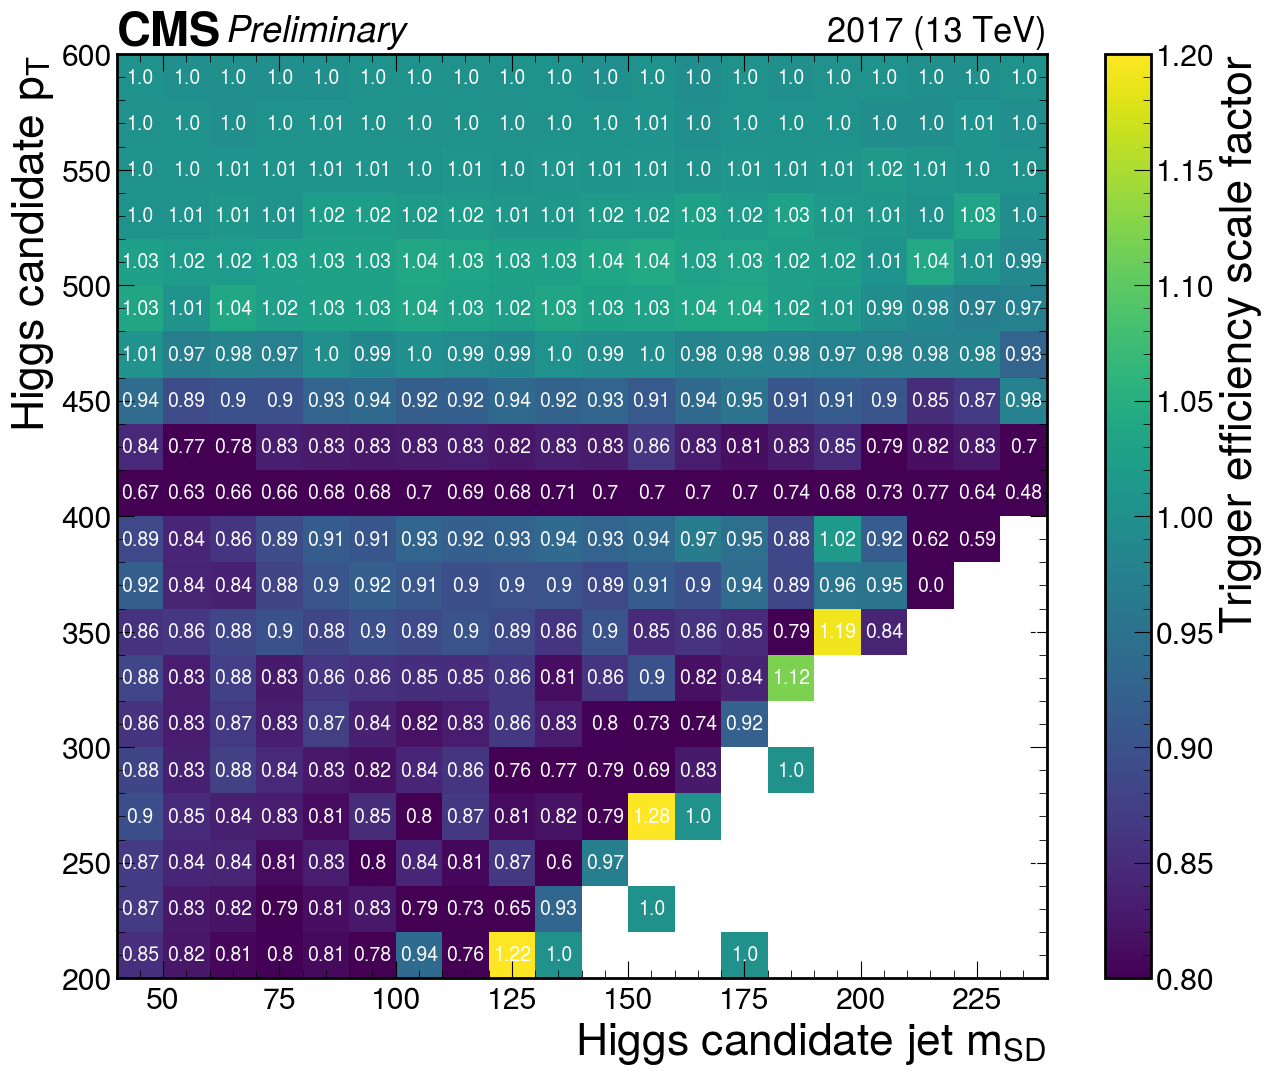

In [9]:
plot_effi_withvalue(eventsMC=events["QCD"], eventsData=events["SingleMuon"],x_label="Mja", y_label = "PTja",legend_location='lower right')

### (optional) plot the 2D trigger efficiency distributionm

In [ ]:
#Plot 2D trigger efficiency SFs.
def distri(eventsMC, x_label, y_label, isData = True, PassTrigger = True, xmin = 200, xmax = 1200, bins = 500, legend_location='best'):
    if x_label == y_label: return
    """
    events: a dictionary, events.values() are collections of events
    """
    x_score, y_score = 'score_'+x_label, 'score_'+y_label
    # ax = plt.figure(figsize=(10,10))
    plt.figure(figsize=(15,12))
    ax=plt.gca()
    # fig ,ax = plt.subplots()
    hep.cms.label(data= isData, label = "Preliminary", year="2017", ax=ax, fontname='sans-serif')
    mmin = 40.0
    mmax = 240.0
    mbins = 20

    ptmin = 200.0
    ptmax = 600.0
    ptbins = 20
    
    hist2D = bh.Histogram(bh.axis.Regular(mbins, mmin, mmax),bh.axis.Regular(ptbins, ptmin, ptmax),storage=bh.storage.Weight())
    eventsMC_Cut = eventsMC[ (eventsMC["HLT_PFJet500"] == True)  | (eventsMC["HLT_AK8PFJet500"] == True) | (eventsMC["HLT_AK8PFJet360_TrimMass30"] == True) | (eventsMC["HLT_PFHT1050"] == True) | (eventsMC["HLT_AK8PFJet380_TrimMass30"] == True) | (eventsMC["HLT_AK8PFJet400_TrimMass30"] == True) | (eventsMC["HLT_AK8PFJet420_TrimMass30"] == True) | (eventsMC["HLT_AK8PFHT750_TrimMass50"] == True) | (eventsMC["HLT_AK8PFHT800_TrimMass50"] == True) | (eventsMC["HLT_AK8PFHT850_TrimMass50"] == True) | (eventsMC["HLT_AK8PFHT900_TrimMass50"] == True)]

    if isData:
        if PassTrigger:     
            hist2D.fill(eventsMC_Cut["Mj_V2_a"],eventsMC_Cut["PTj_V2_a"])
            namestr = "./2DSFPlots/2017DataPass" + y_label + "_vs_" + x_label + ".pdf"
            Namesup = "JetHT(Pass Trigger Combination):"
        else:
            hist2D.fill(eventsMC["Mj_V2_a"],eventsMC["PTj_V2_a"])
            namestr = "./2DSFPlots/2017DataAll" + y_label + "_vs_" + x_label + ".pdf"
            Namesup = "JetHT(All):"
    else:
        if PassTrigger:
            hist2D.fill(eventsMC_Cut["Mj_V2_a"],eventsMC_Cut["PTj_V2_a"],weight = eventsMC_Cut["weight"]*eventsMC_Cut["TriggerSF"])
            namestr = "./2DSFPlots/2017QCDPass" + y_label + "_vs_" + x_label + ".pdf"
            Namesup = "QCD(Pass Trigger Combination):"
        else:
            hist2D.fill(eventsMC["Mj_V2_a"],eventsMC["PTj_V2_a"],weight = eventsMC["weight"])
            namestr = "./2DSFPlots/2017QCDAll" + y_label + "_vs_" + x_label + ".pdf"
            Namesup = "QCD(All):"
    mesh = ax.pcolormesh(*hist2D.axes.edges.T, hist2D.view().value.T )
    plt.colorbar(mesh)
    plt.xlabel(Namesup + r"Higgs candidate jet $m_{SD}$", fontsize=20, ha='right', x=1)
    plt.ylabel(Namesup + r"Higgs candidate $p_{T}$", fontsize=20, ha='right', y=1)
    plt.savefig(namestr, bbox_inches='tight')

    plt.show()

In [ ]:
distri(eventsMC=events["QCD"],isData = False, PassTrigger = True, x_label="Mja", y_label = "PTja",legend_location='lower right')
distri(eventsMC=events["QCD"],isData = False, PassTrigger = False, x_label="Mja", y_label = "PTja",legend_location='lower right')
distri(eventsMC=events["Data"],isData = True, PassTrigger = True, x_label="Mja", y_label = "PTja",legend_location='lower right')
distri(eventsMC=events["Data"],isData = True, PassTrigger = False, x_label="Mja", y_label = "PTja",legend_location='lower right')

In [9]:
#Plot 2D trigger efficiency SFs.
def TriggerEff2D(eventsMC, x_label, y_label, isData = True, xmin = 200, xmax = 1200, bins = 500, legend_location='best'):
    if x_label == y_label: return
    """
    events: a dictionary, events.values() are collections of events
    """
    x_score, y_score = 'score_'+x_label, 'score_'+y_label
    # ax = plt.figure(figsize=(10,10))
    plt.figure(figsize=(15,12))
    ax=plt.gca()
    # fig ,ax = plt.subplots()
    hep.cms.label(data= isData, label = "Preliminary", year="2017", ax=ax, fontname='sans-serif')
    mmin = 40.0
    mmax = 240.0
    mbins = 20

    ptmin = 200.0
    ptmax = 600.0
    ptbins = 20

    if isData:
        eventsData = eventsMC

        hist2DData = bh.Histogram(bh.axis.Regular(mbins, mmin, mmax),bh.axis.Regular(ptbins, ptmin, ptmax),storage=bh.storage.Weight())
        hist2DData.fill(eventsData["Mj_V2_a"],eventsData["PTj_V2_a"])

        eventsData_Cut = eventsData[ (eventsData["HLT_PFJet500"] == True) | (eventsData["HLT_AK8PFJet500"] == True) | (eventsData["HLT_AK8PFJet360_TrimMass30"] == True) | (eventsData["HLT_PFHT1050"] == True) | (eventsData["HLT_AK8PFJet380_TrimMass30"] == True) | (eventsData["HLT_AK8PFJet400_TrimMass30"] == True) | (eventsData["HLT_AK8PFJet420_TrimMass30"] == True) | (eventsData["HLT_AK8PFHT750_TrimMass50"] == True) | (eventsData["HLT_AK8PFHT800_TrimMass50"] == True) | (eventsData["HLT_AK8PFHT850_TrimMass50"] == True) | (eventsData["HLT_AK8PFHT900_TrimMass50"] == True)]

        hist2DData_Cut = bh.Histogram(bh.axis.Regular(mbins, mmin, mmax),bh.axis.Regular(ptbins, ptmin, ptmax),storage=bh.storage.Weight())
        hist2DData_Cut.fill(eventsData_Cut["Mj_V2_a"],eventsData_Cut["PTj_V2_a"])

        Effi2D = hist2DData_Cut.view().value / hist2DData.view().value
        mesh = ax.pcolormesh(*hist2DData.axes.edges.T, Effi2D.T )
        
        xedges = hist2DData.axes[0].edges
        print(xedges)
        yedges = hist2DData.axes[1].edges
        print(yedges)
        h = Effi2D
        print(h)
        for i in range(len(xedges)-1):
            for j in range(len(yedges)-1):
                print(h[i,j])
                plt.text(xedges[i]+0.5*(xedges[i+1]-xedges[i]), yedges[j]+0.5*(yedges[j+1]-yedges[j]), round(h[i,j],2), color='white', ha='center', va='center',fontsize = 14)
        
        Namesup = "JetHT:"
        namestr = "./2DSFPlots_Updated_07052023/2017DataEffi2D" + y_label + "_vs_" + x_label + ".pdf"

    else:
   
        hist2DMC = bh.Histogram(bh.axis.Regular(mbins, mmin, mmax),bh.axis.Regular(ptbins, ptmin, ptmax),storage=bh.storage.Weight())
        hist2DMC.fill(eventsMC["Mj_V2_a"],eventsMC["PTj_V2_a"],weight = eventsMC["weight"])
    
        eventsMC_Cut = eventsMC[ (eventsMC["HLT_PFJet500"] == True)  | (eventsMC["HLT_AK8PFJet500"] == True) | (eventsMC["HLT_AK8PFJet360_TrimMass30"] == True) | (eventsMC["HLT_PFHT1050"] == True) | (eventsMC["HLT_AK8PFJet380_TrimMass30"] == True) | (eventsMC["HLT_AK8PFJet400_TrimMass30"] == True) | (eventsMC["HLT_AK8PFJet420_TrimMass30"] == True) | (eventsMC["HLT_AK8PFHT750_TrimMass50"] == True) | (eventsMC["HLT_AK8PFHT800_TrimMass50"] == True) | (eventsMC["HLT_AK8PFHT850_TrimMass50"] == True) | (eventsMC["HLT_AK8PFHT900_TrimMass50"] == True)]
        
        hist2DMC_Cut = bh.Histogram(bh.axis.Regular(mbins, mmin, mmax),bh.axis.Regular(ptbins, ptmin, ptmax),storage=bh.storage.Weight())
        hist2DMC_Cut.fill(eventsMC_Cut["Mj_V2_a"],eventsMC_Cut["PTj_V2_a"],weight = eventsMC_Cut["weight"]*eventsMC_Cut["TriggerSF"])
    
        Effi2D = hist2DMC_Cut.view().value / hist2DMC.view().value
        mesh = ax.pcolormesh(*hist2DMC.axes.edges.T, Effi2D.T )

        
        xedges = hist2DMC.axes[0].edges
        print(xedges)
        yedges = hist2DMC.axes[1].edges
        print(yedges)
        h = Effi2D
        print(h)
        
        for i in range(len(xedges)-1):
            for j in range(len(yedges)-1):
                print(h[i,j])
                plt.text(xedges[i]+0.5*(xedges[i+1]-xedges[i]), yedges[j]+0.5*(yedges[j+1]-yedges[j]), round(h[i,j],2), color='white', ha='center', va='center',fontsize = 14)
   

        Namesup = "QCD:"
        namestr = "./2DSFPlots_Updated_07052023/2017QCDEffi2D" + y_label + "_vs_" + x_label + ".pdf"





    # plt.title('2D-Trigger Efficiency', fontsize=32,color="black", x = 0.3, y = 0.9)
    cbar = plt.colorbar(mesh)
    cbar.set_label('Trigger efficiency', rotation= 90,fontsize=32)
    plt.xlabel(Namesup + r"Higgs candidate jet $m_{SD}$", fontsize=20, ha='right', x=1)
    plt.ylabel(Namesup + r"Higgs candidate $p_{T}$", fontsize=20, ha='right', y=1)
    plt.savefig(namestr, bbox_inches='tight')

    plt.show()

/tmp/ipykernel_41817/1617117420.py:59: RuntimeWarning: invalid value encountered in divide
  Effi2D = hist2DMC_Cut.view().value / hist2DMC.view().value


[ 40.  50.  60.  70.  80.  90. 100. 110. 120. 130. 140. 150. 160. 170.
 180. 190. 200. 210. 220. 230. 240.]
[200. 220. 240. 260. 280. 300. 320. 340. 360. 380. 400. 420. 440. 460.
 480. 500. 520. 540. 560. 580. 600.]
[[0.79823254 0.79538062 0.79581641 0.78605263 0.77456274 0.74922767
  0.73552341 0.72223419 0.7332397  0.77873485 0.70800065 0.78974632
  0.85459445 0.88531841 0.90689229 0.9350229  0.96476842 0.98393467
  0.99324568 0.99712445]
 [0.69916236 0.68473651 0.68410865 0.68143351 0.67010319 0.6679968
  0.65670264 0.66105511 0.68894613 0.74433163 0.68776693 0.77263979
  0.83875192 0.87204875 0.89690837 0.92691967 0.95947563 0.9814563
  0.9918986  0.99716291]
 [0.73158944 0.71811382 0.70958347 0.70151439 0.68708634 0.67753091
  0.66710848 0.67317836 0.69979009 0.75385922 0.69658965 0.78040198
  0.84849729 0.8792108  0.90307053 0.93171503 0.96242872 0.98340458
  0.99247612 0.99736669]
 [0.74240793 0.73589312 0.72649387 0.72141681 0.70888536 0.69216379
  0.67384998 0.67418121 0.70510

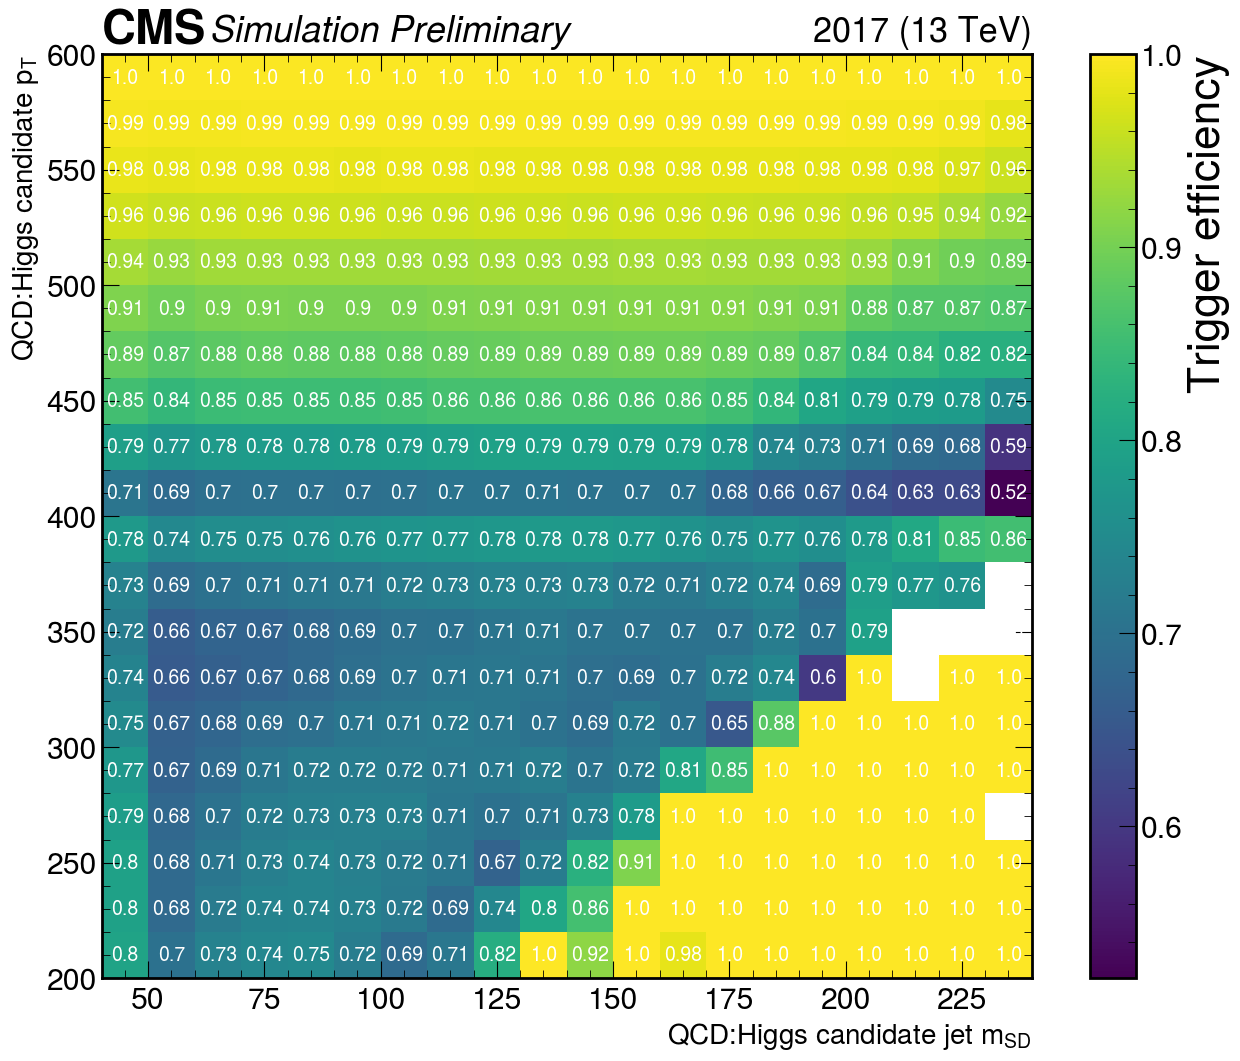

In [7]:
TriggerEff2D(eventsMC=events["QCD"],isData = False,  x_label="Mja", y_label = "PTja",legend_location='lower right')


/tmp/ipykernel_41817/926683803.py:32: RuntimeWarning: invalid value encountered in divide
  Effi2D = hist2DData_Cut.view().value / hist2DData.view().value


[ 40.  50.  60.  70.  80.  90. 100. 110. 120. 130. 140. 150. 160. 170.
 180. 190. 200. 210. 220. 230. 240.]
[200. 220. 240. 260. 280. 300. 320. 340. 360. 380. 400. 420. 440. 460.
 480. 500. 520. 540. 560. 580. 600.]
[[0.84607194 0.85577036 0.86500054 0.86142268 0.85607307 0.84806711
  0.84098184 0.83917454 0.84211929 0.85901459 0.80718357 0.84449101
  0.86301695 0.8841957  0.89928571 0.92239963 0.95568539 0.98000596
  0.9929695  0.99815042]
 [0.7909315  0.79044693 0.79186986 0.79393952 0.78979535 0.78716633
  0.78291805 0.77886766 0.78682417 0.80270182 0.77118657 0.80901985
  0.83541497 0.8644997  0.8895624  0.91818416 0.95181304 0.979123
  0.99211163 0.99707869]
 [0.79686918 0.79775273 0.79975022 0.79670826 0.79626781 0.79150334
  0.79215165 0.79361186 0.8028374  0.82174359 0.78756289 0.82384655
  0.84276471 0.86904403 0.89276347 0.9208166  0.95333303 0.9806932
  0.9931531  0.99780953]
 [0.79508692 0.79867922 0.80291335 0.8032667  0.80048464 0.79914623
  0.79823549 0.80240255 0.815578

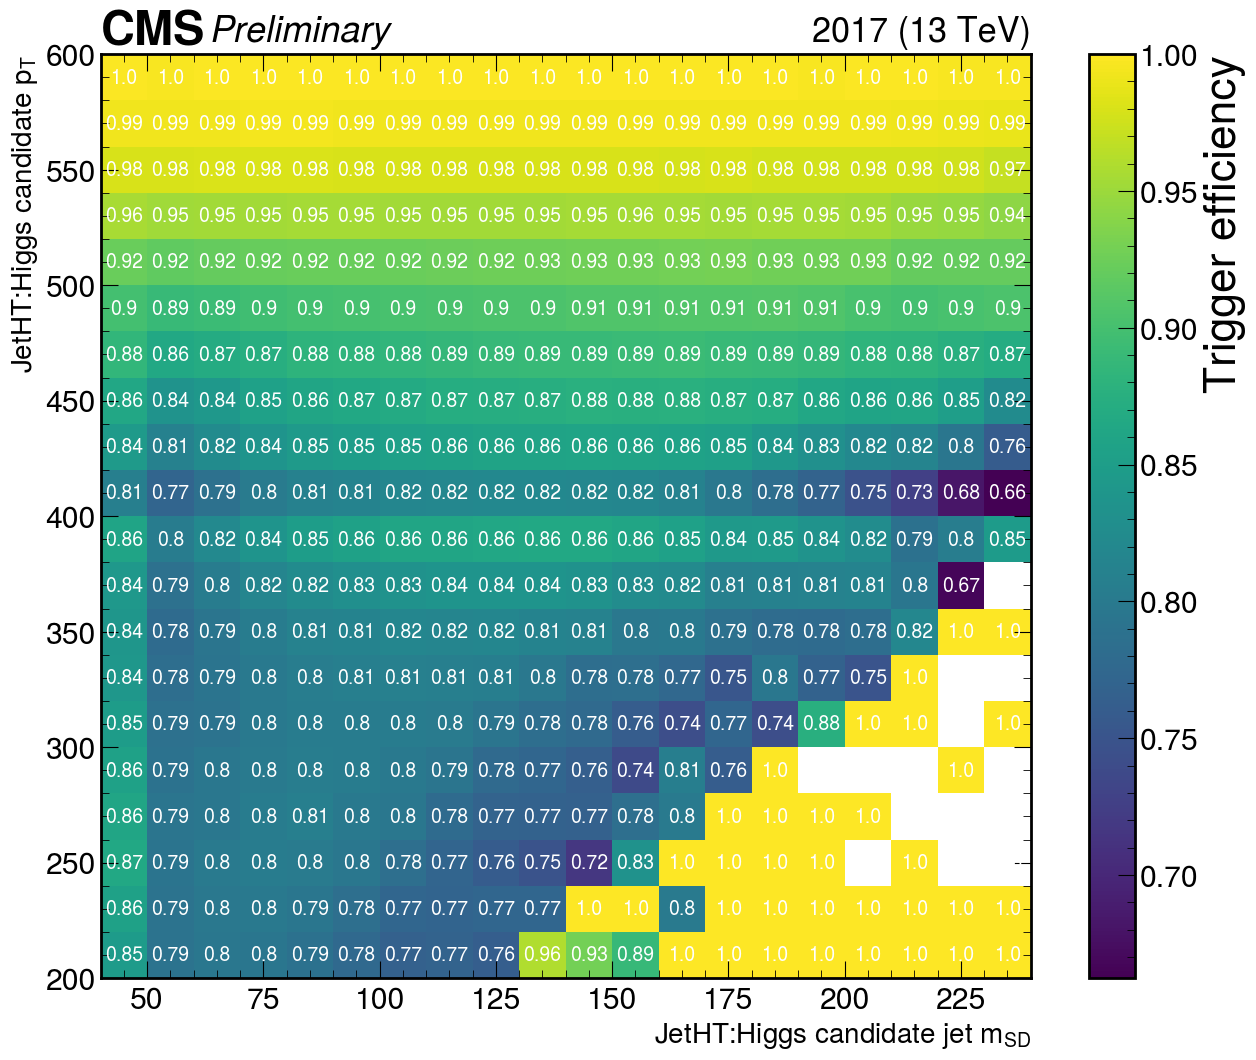

In [10]:
TriggerEff2D(eventsMC=events["JetHT"],isData = True,  x_label="Mja", y_label = "PTja",legend_location='lower right')
